In [2]:
import pandas as pd
import numpy as np
import urllib
import os

from sklearn import model_selection

import tensorflow as tf
import keras as K

import matplotlib.pyplot as plt

from scipy.misc import toimage

%matplotlib inline

Using TensorFlow backend.


Для упрощения работы подключается Google Drive с изображениями и всеми необходимыми данными.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


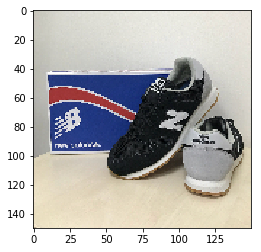

In [4]:
image_file_name = '/content/gdrive/My Drive/NewBalance/Images/train/newbalance/16.jpg'
img = K.preprocessing.image.load_img(image_file_name, target_size=(150, 150))
plt.imshow(img)

In [0]:
train_aug_gen = K.preprocessing.image.ImageDataGenerator(rescale=1/255, 
                                                               zoom_range=0.2,
                                                               channel_shift_range=0.2,
                                                               shear_range=0.2, 
                                                               brightness_range=(0.1, 0.9),
                                                               rotation_range=60,
                                                               width_shift_range=0.2, 
                                                               height_shift_range=0.2, 
                                                               fill_mode='nearest', )

val_aug_gen = K.preprocessing.image.ImageDataGenerator(rescale=1/255, 
                                                               zoom_range=0.1,
                                                               channel_shift_range=0.1,
                                                               shear_range=0.1, 
                                                               brightness_range=(0.3, 0.6),
                                                               rotation_range=60,
                                                               width_shift_range=0.1, 
                                                               height_shift_range=0.1, 
                                                               fill_mode='nearest', )


Иллюстрация работы "генератора агументаций"

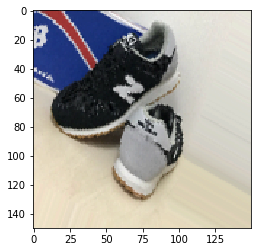

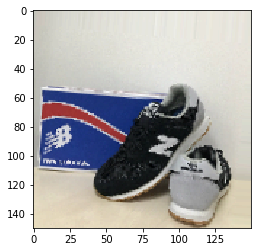

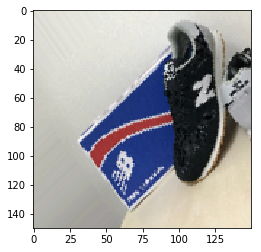

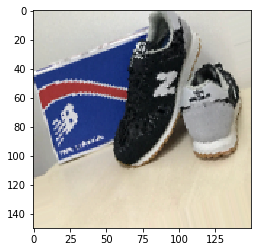

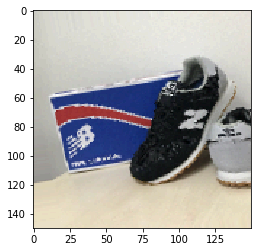

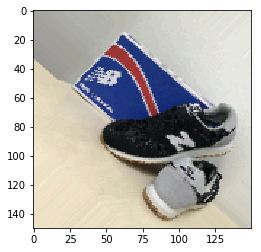

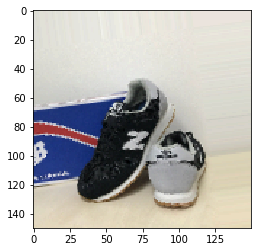

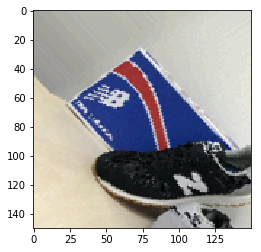

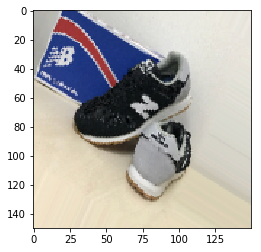

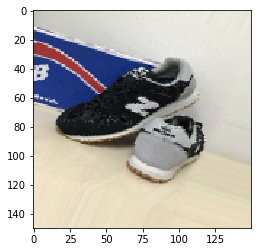

In [6]:
x = K.preprocessing.image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_aug_gen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(K.preprocessing.image.array_to_img(batch[0]))
  i += 1
  if i % 10 == 0:
    break
plt.show()

На тренировочном наборе данных более агрессивная аугментация чем на валидационном.

In [7]:
batch_size = 20
target_size = (224, 224)

train_aug_gen = K.preprocessing.image.ImageDataGenerator(rescale=1/255, 
                                                               zoom_range=0.2,
                                                               channel_shift_range=0.2,
                                                               shear_range=0.2, 
                                                               brightness_range=(0.1, 0.9),
                                                               rotation_range=60,
                                                               width_shift_range=0.2, 
                                                               height_shift_range=0.2, 
                                                               fill_mode='nearest', )

val_aug_gen = K.preprocessing.image.ImageDataGenerator(rescale=1/255, 
                                                               zoom_range=0.1,
                                                               channel_shift_range=0.1,
                                                               shear_range=0.1, 
                                                               brightness_range=(0.3, 0.6),
                                                               rotation_range=60,
                                                               width_shift_range=0.1, 
                                                               height_shift_range=0.1, 
                                                               fill_mode='nearest', )

data_gen = K.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_rand_gen = train_aug_gen.flow_from_directory('/content/gdrive/My Drive/NewBalance/Images/train',
                                                   target_size=target_size, class_mode='binary', batch_size=batch_size)

val_rand_gen = val_aug_gen.flow_from_directory('/content/gdrive/My Drive/NewBalance/Images/val', 
                                            target_size=target_size, class_mode='binary', batch_size=batch_size)

test_gen = data_gen.flow_from_directory('/content/gdrive/My Drive/NewBalance/Images/test',
                                        target_size=target_size, batch_size=batch_size, class_mode='binary')

Found 736 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 163 images belonging to 2 classes.


Было решено попробовать не глубокую сеть, собственного сочинения, для упрощения обучения. Так как задача достаточно простая, а набор данных достаточно маленький, большая нейронная сеть будет с обучаться с трудом, если вообще будет.

In [8]:
model = K.models.Sequential()

model.add(K.layers.Conv2D(32, (3,3), input_shape=(224, 224, 3), activation='relu'))
model.add(K.layers.MaxPool2D(pool_size=(2,2)))

model.add(K.layers.Conv2D(32, (3,3), activation='relu'))
model.add(K.layers.MaxPool2D(pool_size=(2,2)))

model.add(K.layers.Conv2D(64, (3,3), activation='relu'))
model.add(K.layers.MaxPool2D(pool_size=(2,2)))

model.add(K.layers.Conv2D(128, (3,3), activation='relu'))
model.add(K.layers.MaxPool2D(pool_size=(2,2)))

model.add(K.layers.Flatten())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       73856     
__________

In [0]:
checkpoint = K.callbacks.ModelCheckpoint('/content/gdrive/My Drive/NewBalance/my_cnn.hdf5',
                                         monitor='val_acc', save_best_only=True, verbose=1 )
learning_rate_reduction = K.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=0, factor=0.2, verbose=1)

In [0]:
model.load_weights('/content/gdrive/My Drive/NewBalance/my_cnn.hdf5')

In [15]:
history = model.fit_generator(train_rand_gen, epochs=200, validation_data=val_rand_gen, 
                              use_multiprocessing=True,
                              steps_per_epoch=train_rand_gen.samples//batch_size, 
                              validation_steps=val_rand_gen.samples//batch_size,
                              callbacks=[checkpoint])

Epoch 1/200
36/36 [==============================] - 84s 2s/step - loss: 0.1300 - acc: 0.9569 - val_loss: 0.4320 - val_acc: 0.8778

Epoch 00001: val_acc improved from -inf to 0.87778, saving model to /content/gdrive/My Drive/NewBalance/my_cnn.hdf5
Epoch 2/200
36/36 [==============================] - 56s 2s/step - loss: 0.1471 - acc: 0.9427 - val_loss: 0.5129 - val_acc: 0.8902

Epoch 00002: val_acc improved from 0.87778 to 0.89024, saving model to /content/gdrive/My Drive/NewBalance/my_cnn.hdf5
Epoch 3/200
36/36 [==============================] - 65s 2s/step - loss: 0.2120 - acc: 0.9215 - val_loss: 0.4757 - val_acc: 0.8780

Epoch 00003: val_acc did not improve from 0.89024
Epoch 4/200
36/36 [==============================] - 65s 2s/step - loss: 0.1854 - acc: 0.9368 - val_loss: 0.2899 - val_acc: 0.9146

Epoch 00004: val_acc improved from 0.89024 to 0.91463, saving model to /content/gdrive/My Drive/NewBalance/my_cnn.hdf5
Epoch 5/200
36/36 [==============================] - 61s 2s/step - l

Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/mu

Epoch 1/200


  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 100, in __next__
    return self.next(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 112, in next
    return self._get_batches_of_transformed_samples(index_array)
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 234, in _get_batches_of_transformed_samples
    x = self.image_data_generator.apply_transform(x, params)
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py", line 867, in apply_transform
    x = apply_brightness_shift(x, transform_parameters['brightness'])
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/affine_transformations.py", line 212, in apply_brightness_shift
    x =

Epoch 1/200


KeyboardInterrupt: ignored

In [17]:
loss, acc = model.evaluate_generator(test_gen, steps=test_gen.samples//batch_size)

print(acc)

0.8750000074505806


Иллюстрация того как наша модель обучается от эпохи к эпохе. При обучении loss должен уменьшаться, а accurcy (acc) должна возрастать.

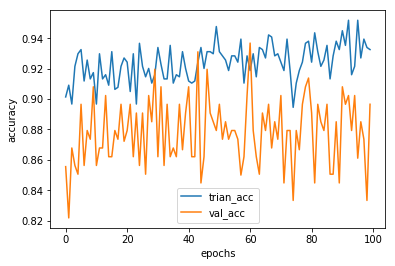

In [20]:
plt.plot(history.history['acc'], label='trian_acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

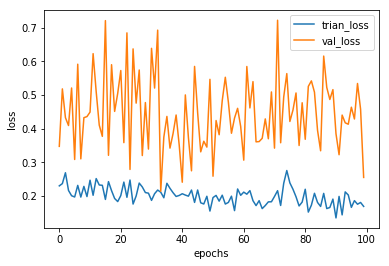

In [21]:
plt.plot(history.history['loss'], label='trian_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/NewBalance/my_cnn_1.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("/content/gdrive/My Drive/NewBalance/my_cnn_1_200epochs.hdf5")

Иллюстрирация каждого сверточного слоя

In [0]:
path_img = '/content/gdrive/My Drive/NewBalance/Images/train/newbalance/33.jpg'
img = K.preprocessing.image.load_img(path_img, target_size=(224, 224))
img_array = np.expand_dims(K.preprocessing.image.img_to_array(img), axis=0)/255

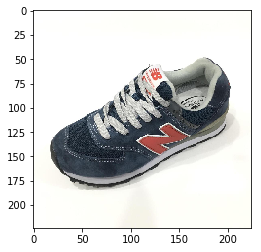

In [12]:
plt.imshow(img)

In [0]:
def activation(model, num_layer, img):
  
  img_array = np.expand_dims(K.preprocessing.image.img_to_array(img), axis=0)/255
  
  activation_model = K.Model(inputs=model.input, outputs=model.layers[num_layer].output)
  
  activation = activation_model.predict(img_array)
  print(activation.shape)

  images_per_row = 16
  n_filters = activation.shape[-1]
  size = activation.shape[1]
  n_cols = n_filters // images_per_row

  display_grid = np.zeros((n_cols * size, images_per_row * size))

  for col in range(n_cols):
      for row in range(images_per_row):
          channel_image = activation[0, :, :, col * images_per_row + row]
          channel_image -= channel_image.mean()
          channel_image /= channel_image.std()
          channel_image *= 64
          channel_image += 128
          channel_image = np.clip(channel_image, 0, 255).astype('uint8')
          display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.grid(False)
  
  return(plt.imshow(display_grid, aspect='auto', cmap='viridis'))

(1, 222, 222, 32)
(1, 111, 111, 32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


(1, 109, 109, 32)
(1, 54, 54, 32)
(1, 52, 52, 64)
(1, 26, 26, 64)
(1, 24, 24, 128)
(1, 12, 12, 128)


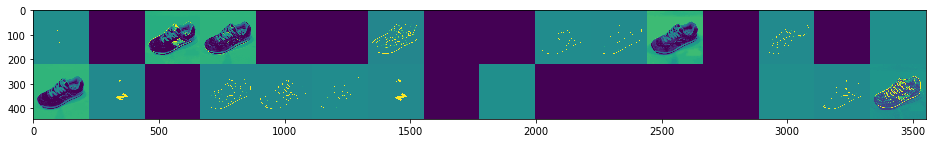

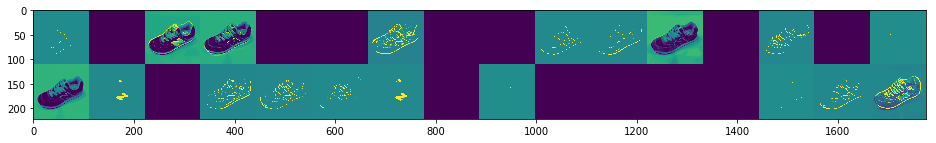

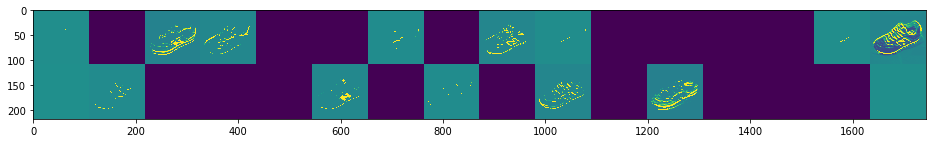

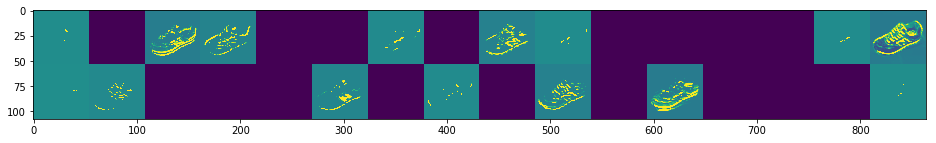

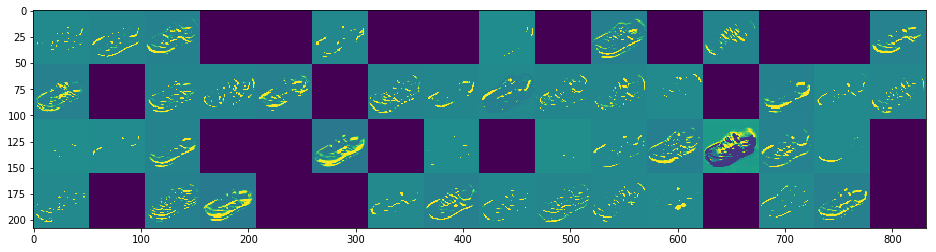

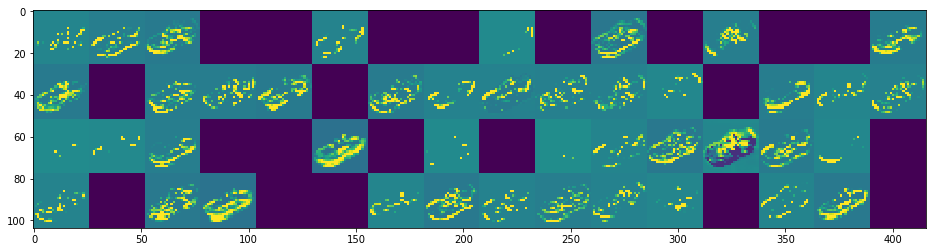

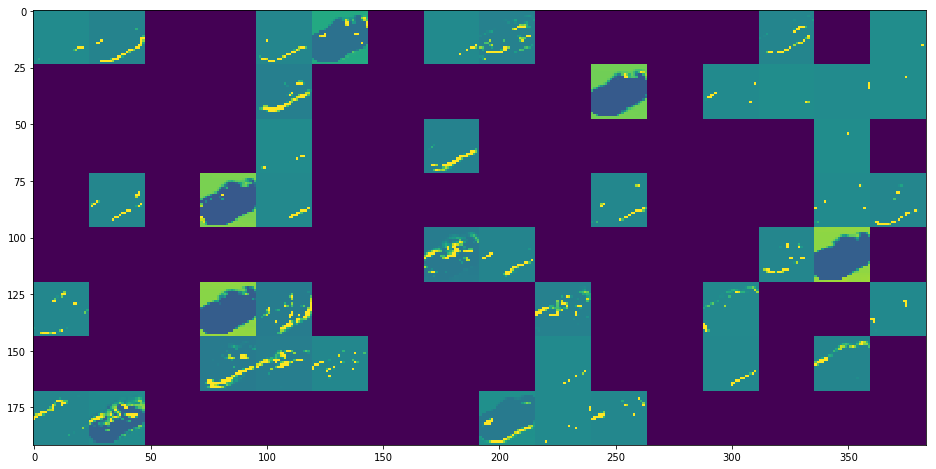

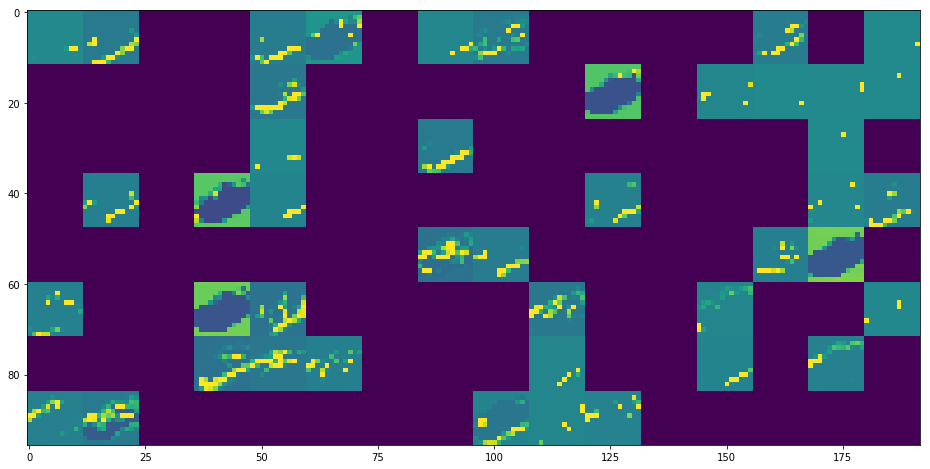

In [14]:
for i in range(8):
  activation(model, i, img)

На изображениях желтым цветом выделены активации, видно что модель при предсказаниях ориентируется на фасон на подошву и как видно из этого конкретного примера на логотип.

На последних слоях можно заметить вклад фона на котором делали фото. Из чего следует что в данных много однотипных изображений.


Все из мною рассмотренных моделей достаточно сильно реагируют на подошву. Это может быть связанно как с уникальностью подошвы. Так и с маленьким набором данных.